## Fit field-based connective field models

In [ ]:
%load_ext autoreload
%autoreload 2

from vicsompy.surface import Subsurface
import numpy as np
from vicsompy.modeling import MssCf
from vicsompy.surface import CiftiHandler
from vicsompy.subject import HcpSubject
from vicsompy.surface import CiftiHandler
mch=CiftiHandler()
import pandas as pd
import cortex
from vicsompy.vis import basic_plot
import itertools
from tqdm import tqdm
import os
from vicsompy.utils import load_pkg_yaml
import pkg_resources


In [3]:
my_sub = HcpSubject(subject='999999',experiment_id='movie')
my_sub.prep_data() # Prep data paths
my_sub.prepare_out_dirs('TEST')

In [21]:
rois=["VISPATH_1n",
        "VISPATH_2",
        "VISPATH_3",
        "VISPATH_4_n",
        "VISPATH_5",
        "VISPATH_6n",
        "VISPATH_7",
        "VISPATH_8",
        "VISPATH_1_R",
        "VISPATH_2_R",
        "VISPATH_3_R",
        "VISPATH_4_R",
        "VISPATH_5_R",
        "VISPATH_6_R",
        "VISPATH_7_R",
        "VISPATH_8_R","Medial", "Parietal", "Frontal", "Operculum-insula"]

In [22]:
rois=cortex.utils.get_roi_verts('hcp_999999_draw_NH',rois,mask=True)

In [23]:
any_roi_mask = np.any(list(rois.values()), axis=0)
any_roi_mask

array([False,  True,  True, ..., False, False, False])

In [ ]:
def fit_field_model(field,subject,experiment_id='movie',analysis_name='TEST'):
    my_sub = HcpSubject(subject=subject,experiment_id=experiment_id)
    my_sub.prep_data() # Prep data paths
    my_sub.import_data() # Import data
    my_sub.prepare_out_dirs(analysis_name) # Prepare output directories

    data_train=my_sub.brainmodel.decompose_data(my_sub.all_data.T) # Decompose data into surface and subcortical components.
    data_test=my_sub.brainmodel.decompose_data(my_sub.concatenated_test_sequence.T) # Decompose data into surface and subcortical components.
    nm=MssCf(my_sub,analysis_name=analysis_name,yaml=os.path.join(pkg_resources.resource_filename("vicsompy", 'config'),'config_{field}.yml'.format(field=field))) # Initialise based on the subregion.
    nm.make_subsurfaces() 
    nm.make_dm(np.nan_to_num(data_train[0])) # Make design matrix.
    nm.prep_pipeline(run_durations=my_sub.run_onsets) # Prepare ridge regression pipeline, specifying run durations for cross-validation.
    s,c=mch.decompose_data(my_sub.all_data.T)
    fit_data=s[any_roi_mask,:].T.astype('float16')

    nm.fit(np.nan_to_num(fit_data)) # Fit model.
    nm.get_params() 

    s2,c2=my_sub.brainmodel.decompose_data(my_sub.concatenated_test_sequence.T)
    test_data=s2[any_roi_mask,:].T.astype('float16')

    nm.test_xval(np.nan_to_num(data_test[0]),np.nan_to_num(test_data)) 
    
    somframe = pd.DataFrame({'within_r2_som': nm.split_scores[1], 'test_r2_som': nm.test_split_scores[1]})

    out_dir = os.path.join(my_sub.out_base,analysis_name,'csvs/{subject}'.format(subject=subject))
    somframe.to_csv(f'{out_dir}/somatic_fields_{field}_n.csv'.format(field))
    return somframe



Set up the list of subjects and the field of interest.

In [ ]:
fields=['face','UL','T','LL']
subjects = ['999999','movsplit_1','movsplit_2','subsplit_1','subsplit_2']

combinations = list(itertools.product(fields,subjects))
df_combinations = pd.DataFrame(combinations, columns=['field', 'subject'])
df_combinations

Fit

In [ ]:
for i in tqdm(range(0,len(df_combinations))):
    fit_field_model(**df_combinations.loc[i].to_dict())

Define functions for getting the cross-validated fits for the field model and original model.

In [19]:
def load_field_vexpl(sub,field,analysis_name='TEST'):
    path=os.path.join(my_sub.out_base,analysis_name,'csvs/{subject}'.format(subject=sub))
    file=os.path.join(path,'somatic_fields_{field}_n.csv'.format(field=field))
    somatic_fields = pd.read_csv(file,index_col=0)
    vexpl=somatic_fields['test_r2_som']
    return vexpl

def load_full_vexpl(sub,analysis_name='TEST'):
    path=os.path.join(my_sub.out_base,analysis_name,'csvs/{subject}'.format(subject=sub))
    file=os.path.join(path,'params.csv')
    somatic_fields = pd.read_csv(file,index_col=0)
    vexpl,sub=mch.decompose_data(somatic_fields['test_scores_somato_score'])
    return vexpl

def get_winner(sub):
    empt=np.zeros(118584)
    UL=load_field_vexpl(sub,'UL')
    face=load_field_vexpl(sub,'face')
    LL=load_field_vexpl(sub,'LL')
    T=load_field_vexpl(sub,'T')
    stack=np.vstack([face,UL,T,LL])
    winner=np.argmax(stack,axis=0)
    big_vexpl=[stack[v,c] for c,v in tqdm(enumerate(winner))]
    empt[any_roi_mask]=big_vexpl
    return empt

Plot the difference between the field model and original model.

In [24]:
from tqdm import tqdm
winner=get_winner('999999')

44459it [00:00, 2382330.81it/s]


In [25]:
orig=load_full_vexpl('999999')

In [13]:
diff=orig-winner

In [14]:
diff[~any_roi_mask]=np.nan

from vicsompy.utils import MmpMasker
mmsk=MmpMasker()
threebmask=mmsk.make_roi_mask('3b')
diff[threebmask[-1]]=np.nan

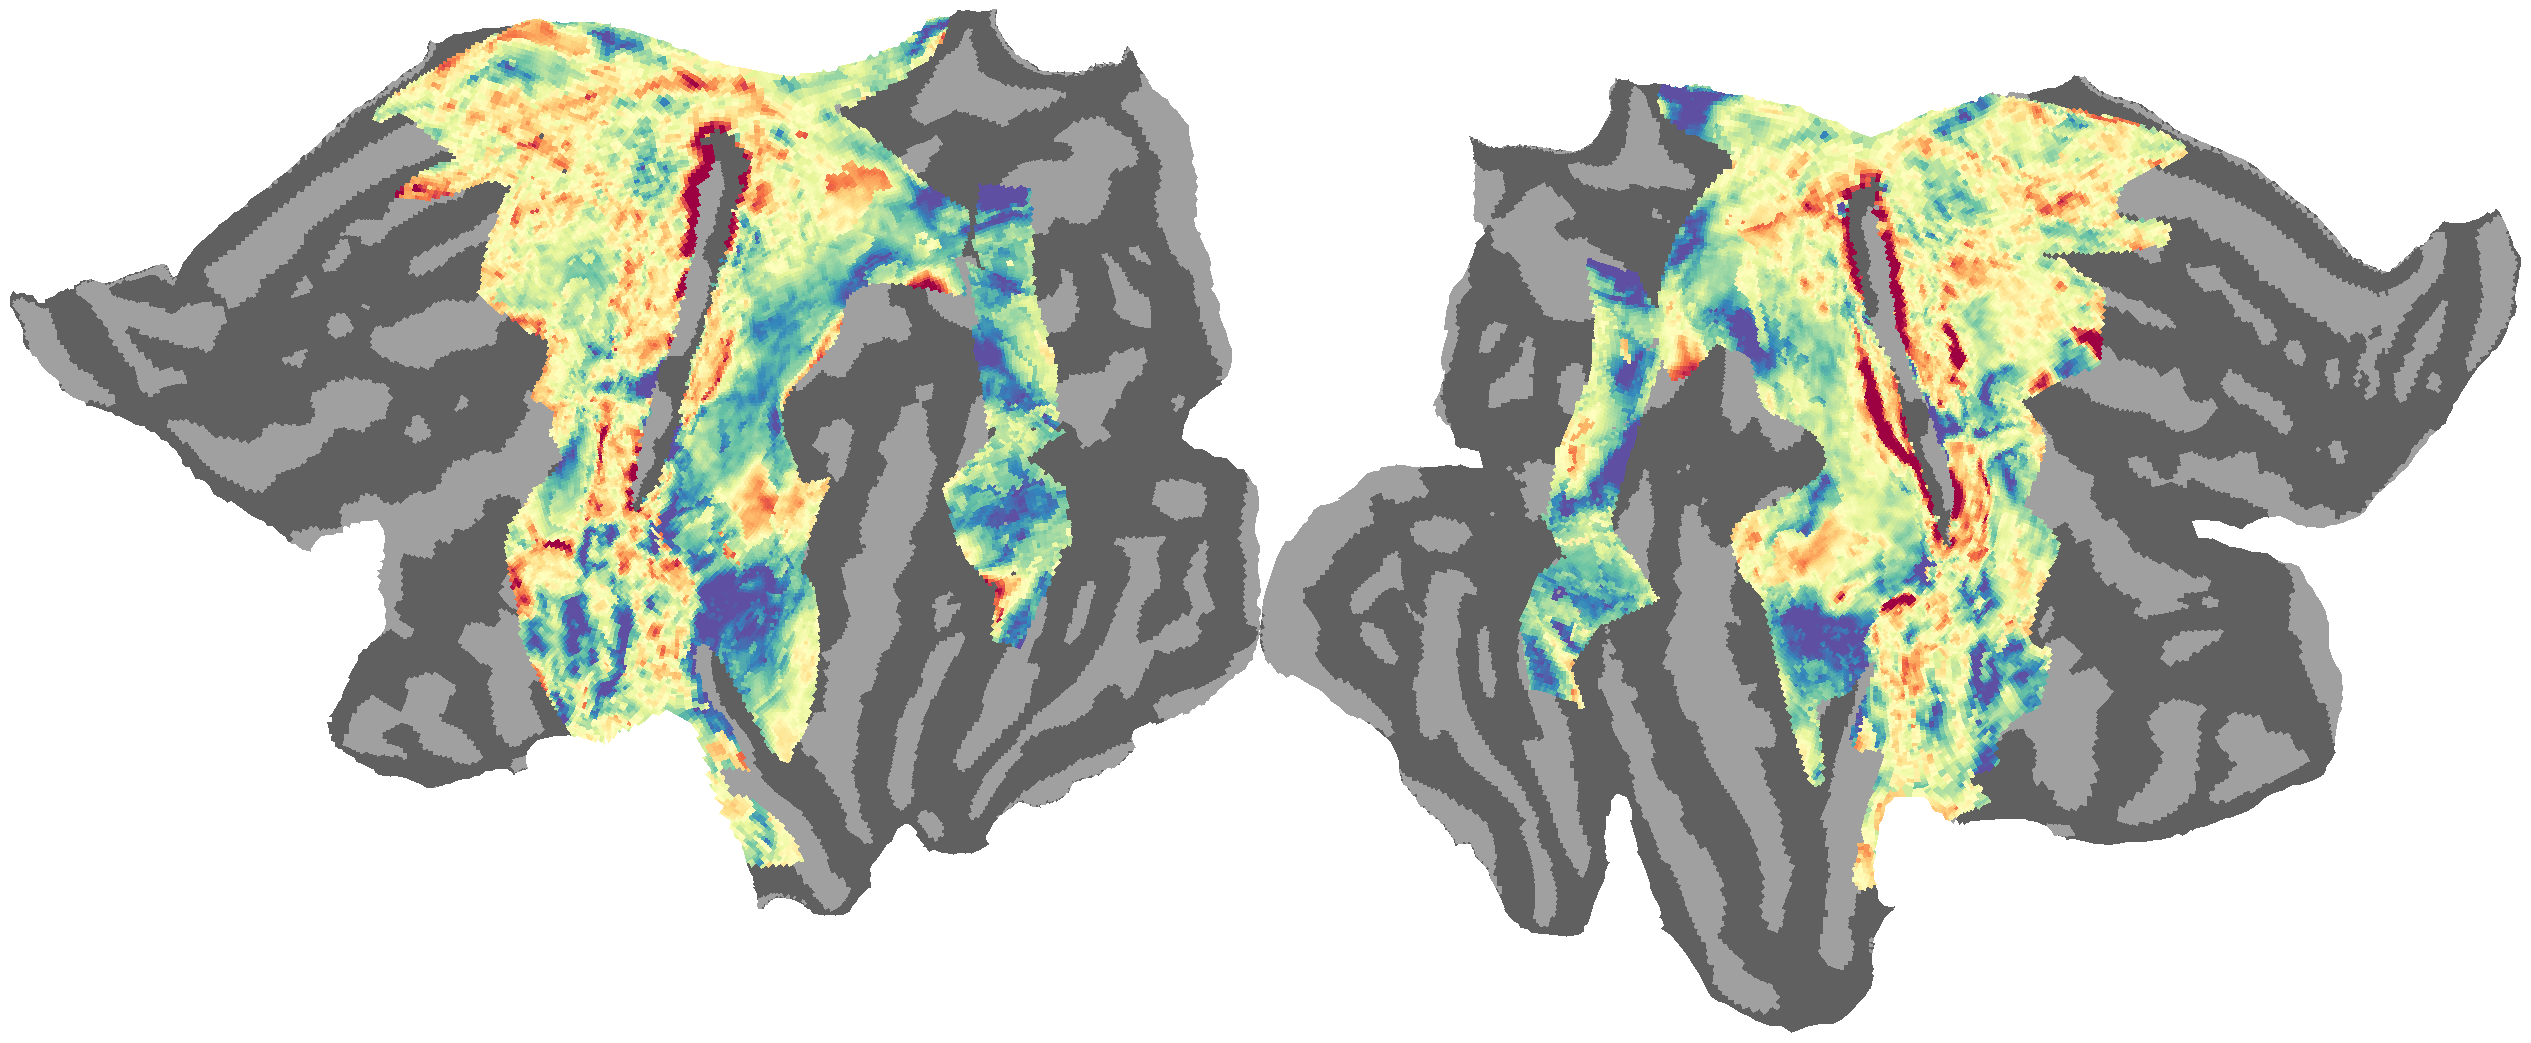

In [17]:
bp=basic_plot(diff,vmin=-.1,vmax=.1,cmap='spectral')

Concatenate these results into a dataframe and save out.

In [ ]:
from tqdm import tqdm
subjects=['movsplit_1','movsplit_2','subsplit_1','subsplit_2'] # List of subjects to analyze
winners=[get_winner(sub) for sub in subjects]
full_vexpls= [load_full_vexpl(sub) for sub in tqdm(subjects)]

44459it [00:00, 2441117.98it/s]
44459it [00:00, 2455648.25it/s]
44459it [00:00, 2514082.96it/s]
44459it [00:00, 2518054.98it/s]


In [22]:
frames=[]
for i in range(len(full_vexpls)):
    full_vexpls[i][~any_roi_mask]=np.nan
    winners[i][~any_roi_mask]=np.nan
    frames.append(pd.DataFrame({'full_vexpl':full_vexpls[i],'winner':winners[i]}))
    frames[i]=frames[i].assign(subject=subjects[i])


In [ ]:
lframe=pd.concat(frames)
lframe.to_csv(os.path.join(load_pkg_yaml()['paths']['plot_out'],'split_field_results.csv'))